
<div align="center"> <h1>Gobal Convergence of Policie Gradient Methods: Review and Application on Cartpole Problem</h1></div> <br/ >



<div align="center">  HILDA IBRIGA </div>

## I. Introduction 
  
 In this post, I bring together the elements necessary for getting a better understanding of the problem solutions provided in the 2019 paper by Fazel et al titled 
 [*"Global Convergence of Policy Gradient Method for Linearized Control Problems"*](https://arxiv.org/abs/1801.05039). I also provide the intuition behind the proof technique used in the
paper and run a simulation analysis comparing two specific algorithms derived from the family of
methods for which the author proved global convergence. This document is presented in three parts as follows:

- **Part 1:** I introduce some background information by presenting the reader with a brief
 refresher on Reinforcement Learning and it framework. I also expose the differences between reinforcement learning and optimal control theory and how proof techniques from control theory can help in proving convergence guarantees in reinforcement learning. I present the LQR problem and the algorithm proposed by the authors for solving the problem.  
 
 
- **Part 2:** I state the main theorem of the paper and provide a detail proof sketch of the theorem in three parts.   


- **Part 3:** The paper is a purely theoretical paper and although an algorithm is proposed no simulation nor application are carried by the authors. I therefore adjust and apply one of the methods for which the authors proved convergence to the cart-pole reinforcement learning problem. I provide the python and tensorflow code that I used for the simulation as well as a video animation showing how my simulation performed in a virtual environment.
 
## II. BACKGROUND
 
 Reinforcement learning is an important type of Machine Learning where an agent learn how to behave in an environment by performing actions and seeing the results. Any reinforcement learning problem can be mathematically formulated using the *state-agent-action-cost*/*state-agent-action-reward* framework. This framework works as follows:
 
 - Step 1: The Environment reveals state $x_0$ to the agent.
 - Step 2: Based on the revealed state $x_0$, the agent takes an action $u_0$.
 - Step 3: the Environment transitions to a new state $x_1$ and gives some reward $r_1$ or reveals the cost $c_1$ of the action taken by the agent.

This sequence of state-action-reward is repeated until the end of the interaction between agent and environment or is repeated indefinitely in the case of an infinite horizon process.  

The goal of the agent in a RL problem is then to learn the sequence of actions $ u_0,...,u_t$ which will lead to the greatest cumulative reward.  

### Similarities and Differences between RL and Optimal Control Theory

Although the above framework was introduced as belonging to Reinforcement Learning, it could also be labelled as an Optimal Control theory framework.  

Optimal Control theory and Reinforcement Learning are very similar in that they both seeks to find the sequence of actions which leads to the most reward when an agent interact with an environment. The main difference between the two areas is in the representation of the environment.  

Control theory was originally  born from the engineering fields where the environment behavior is often regulated by well known physics laws. Therefore in optimal control theory the environment state transition function is known or can be mathematically modelled. The goal is then to find the sequence of actions given the known state transition which yields the best reward.  

On the other hand in RL the state transition of the environment (environment behavior) is usually not known. The agent therefore collects data by interacting with the environment not only to learn the best actions but also to learn about the state transition of the environment. <br/ >  


<img src=attachment:reinvscont2.PNG alt="reinvscont2.PNG" class="bg-primary mb-1" width="600px"> 
<center> **Table.1:** Difference between RL and Control Threory </center>  

### The Linear Quadratic Regulator problem (LQR)

The paper provides convergence guarantees for model free RL methods solving a very specific problem known as the Linear Quadratic Regulator problem. In the LQR problem the state transition is parametrized to be a linear function of the state and action and the reward/cost function is parametrized to be a quadratic function of the state and action. That is:

\begin{equation}
     x_{t+1}=A_tx_t+B_tu_t
\end{equation}

\begin{equation}
     c_t= x^{T}_{t}Qx_{t}+u^{T}_{t}Ru_{t} 
\end{equation}

where $ A \in R^{d\times d}$, $B \in R^{d\times k}$, are transition matrices and $ Q \in R^{d\times d}$ $ R \in R^{k\times k}$ are both positive definite matrices.

The RL problem is then formulated as an optimization problem as follows

\begin{equation}
           \texttt{minimize } \mathop{\mathbb{E}}\left[\sum^{\infty}_{\infty}(x^{T}_{t}Qx_{t}+u^{T}_{t}Ru_{t})\right]
            \texttt{such that } x_{t+1}=A_tx_t+B_tu_t \texttt{, } x_0 \sim \textit{D}  
            \label{eq:vector_ray} \tag{1}
 \end{equation}
 
That is, we seek to find the sequence of actions which minimizes the expected cumulative cost under the condition that the environment state transition function is linearly parameterized.  

Notice that this is still a RL learning problem and not a Optimal Control theory problem since the parameters $A$, $R$, $Q$, and $B$ are unknown.  
If the parameters $A$, $R$, $Q$, and $B$ were known then the LQR problem becomes a classical optimal control theory problem which has been well studied in the optimal control theory field and performance results are known. In control theory it is known that the optimal action sequence for this problem can be written as a linear combination of the state. That is the

\begin{equation}
u_t=-K^{*}x_t
\end{equation}

where $K^*\in R^{k \times d}$ is defined as:
\begin{equation}
 K=-(B^{T}PB+R)^{-1}B^{T}PA
 \end{equation}
and
\begin{equation}
 P=A^{T}PA+Q-A^{T}PB(B^{T}PB+R)^{-1}B^{T}PA  
  \label{eq:p} \tag{2}
\end{equation}

Notice that equation $\eqref{eq:p}$ is a second order differential equation which is quadratic in the unknown parameter $P$. When $A$, $R$, $Q$, and $B$ are known ( which is the case for control theory) This equation can be solved in a closed form.  
However in the RL setting $A$, $R$, $Q$, and $B$ are unknown parameters. The idea in this paper is to use a method of estimating the optimal policy using a sample based stochastic method approach and once that is done,  borrow tools from optimal control theory to provide convergence guarantees for a family of RL algorithm for the LQR problem.

### Intuition behind the model free sample based policy gradient method

There are two main approaches to solving reinforcement learning problem:  
- **Model-based approach:** this is the case in which the agent attempts to learn a model of the environment.


- **Model-free approach** this is the case in which the agent directly learns the actions without having an explicit knowledge of the environment. The work in the paper focuses on a type of model-free method known as the **sample based policy gradient methods**. I provide some intuition as to how  this type of method works in the next few paragraphs.

Since it is known from optimal control theory that the optimal policy can be written as a linear combination of the state 
$ u_t=-K^{*}x_t$ then the cost of the policy $K$ can be written as:

\begin{equation}
           C(K):= \mathop{\mathbb{E}_{x_0 \sim D}}\left[\sum^{\infty}_{\infty}(x^{T}_{t}Qx_{t}+u^{T}_{t}Ru_{t})\right]
            \label{eq:c} \tag{3}
\end{equation}

The optimal policy can be found by minimizing the cost function $C(K)$ with respect to K subject to $u_t=-K^{*}x_t$.
\begin{equation}
           C(K):= \mathop{\mathbb{E}_{x_0 \sim D}}\left[\sum^{\infty}_{\infty}(x^{T}_{t}Qx_{t}+u^{T}_{t}Ru_{t})\right]
           \text{subject to } u_t=-K^{*}x_t \text{ and } x_0 \sim \textit{D}
     \label{eq:cmax} \tag{4}
\end{equation}

This optimization can be solved using, gradient descent methods or the natural gradient policy. Therefore there is a need to derive the policy gradient $\nabla C(K)$. Which is obtained as: 

\begin{equation}
\nabla C(K)=2\left( (R +B^T P_K B)K- B^T P_K A)\Sigma_K \right)
\end{equation}

where $\Sigma_{K}^{-1}=\mathop{\mathbb{E}_{x_0 \sim D}}\sum^{\infty}_{t=0}x_tx^{T}_{t}$ is the Fisher information matrix of the state transition.   

Once the gradient is obtained an update of the gradient algorithms would then be:

- Gradient descent: $K_{n+1}=Kn-\eta \nabla C(K)$
- Natural policy Gradient descent: $K_{n+1}=Kn-\eta \nabla C(K)\Sigma_{K}^{-1}$.

At first glance, this seems like an easy problem to implement, however the gradient $\nabla C(K)$ cannot be derived explicitly since in the model free case the parameters $A$, $R$, $Q$, and $B$ are all unknown.  

The solution to this issue is provided in \textbf{Algoirthm 1} in paper which consists of producing Monte Carlo simulations of the policy model $K$ using a perturbation of $K$ on the unit sphere. This is followed by getting the estimates of the gradient $\widehat{\nabla C(K)}$ and fisher information matrix $\widehat{\Sigma_K}$ using the empirical means of the simulated cost and fisher information. 

<img src=attachment:algo1.PNG alt="algo1.PNG" class="bg-primary mb-1" width="600px"> 


## Theorem and Proof Sketch

The main theorem of the paper shows that although the optimization is a non-convex problem and the gradient and fisher information are not exact but empirical estimates; that both methods (sample based gradient descent and natural gradient policy method) converge to the optimal policy at a polynomial rate. The next section presents the theorem and a sketch of it's proof.


### Theorem: *Global convergence of sample based policy gradient algorithm*

* Suppose $ C(K_0)$ is finite, $\mu>0$, and that $x_0 \sim D$ has a norm bounded by $L$ almost surely. Also supposed Algorithm 1 is called with parameters:* 

\begin{equation}
 \text{m, l, 1/r}=\text{ poly }\left( C(K_0), \frac{1}{\mu}, \frac{1}{\sigma_{min} (Q)},\|A\|,\|B\|,\|R\|,\frac{1}{\sigma_{min} (R)},D,\frac{1}{\epsilon},\frac{L^2}{\mu}\right)
\end{equation}
then 
- Natural policy gradient case: for stepsize

\begin{equation}
\eta= \frac{1}{ \| R\| + \frac{\| B\|^2 C(K_0)}{\mu}}
\end{equation}
*and for*
\begin{equation}
 N \geq \frac{\|\Sigma_{K^*} \|}{\mu} \left( \frac{\|R \|}{\sigma(R)}+\frac{\|B \|^2C(K_0)}{\mu \sigma_{min}(R)}\right)log\frac{2( C(K_0)-C(K^*))}{\epsilon}
\end{equation}
 
then, with high probability $1-exp(-d)$, the gradient descent update enjoys the following bound: 
\begin{equation}
    C(K_N)-C(K^*)\leq \epsilon.
\end{equation}

- Gradient descent case: for stepsize
\begin{equation}
\eta= \text{poly } \left( \frac{\mu \sigma(Q)}{c(K_0)}, \frac{1}{\|A\|}, \frac{1}{\|B\|}, \frac{1}{\|R\|},\sigma_{min} (R)\right)
\end{equation}
*and for*

\begin{equation}
 N \geq \frac{\|\Sigma_{K^*} \|}{\mu} log\frac{( C(K_0)-C(K^*)}{\epsilon}* \text{poly }\left( \frac{C(K_0)}{\mu \sigma_{min} (Q)},\|A\|,\|B\|,\|R\|,\frac{1}{\sigma_{min}(R)} \right)
\end{equation}
*then, with high probability $1-exp(-d)$, the natural gradient descent update enjoys the following bound: *
\begin{equation}
    C(K_N)-C(K^*)\leq \epsilon.
\end{equation}

**Remark:** it is worth noting that the sample based natural policy gradient method has theoretically a higher convergence rate than than the sample based gradient descent method.  

This is due to the fact that more information is provided in the one step update for the natural policy gradient than the simple gradient descent case.

### Proof Sketch

In order to provide some intuition to the proof of the main theorem, I break of the sketch of the proof into three parts. These three parts represent the three area of difficulties for completing the proof.

- Section 3.2.1: Characterizing the non-convexity of the problem
- Section 3.2.2: Gradient Dominant ion and Almost Continuity of the objective function $ C(K)$
- Section 3.2.3: Applying the Zeroth Order optimization method


#### Characterizing the non-convexity of the problem
The optimization problem in equation $\eqref{eq:cmax}$ is non-convex which means that even if the sample based policy method converges it is not guaranteed to converge to a global optima and can get stuck at a local optima. Hence the first step in the proof of the theorem is to reveal the characteristics of the non-convexity of the problem. This is done through Lemma 2 and Corollary 3.  

The authors start by looking at the case in which the gradient $ \nabla C(k)$ and fisher information matrix $\Sigma_k$ are known. Remember that this is not the case for the sample based gradient descent and natural policy gradient methods but it is a starting point for the proof. The idea is that once the problem is solved for the exact gradient and fisher information case the zeroth order optimization strategy introduced algorithm 1 will lead to showing the result for the sample based case.  

Lemma 2 shows that for state dimension $d\geq3$ there exists a LQR problem which objective function is not convex, not quasi convex or star convex.

Although the problem is non-convex the authors then go to show that in the case of the LQR problem gradient descent and the natural policy gradient descent might still converge to a global optima. This demonstrated using Corollary 3, where it is shown that when $\nabla C(K)$ then there are two possibilities.

1. K is an optimal policy or
2. $ \Sigma_K$ is rank deficient.

With this characterization of the non-convexity of the problem. It becomes clear how we can guarantee that the gradient descent will converge to the global optima. That is as long as we ensure that the fisher information matrix of the state space $\Sigma_K$ is not rank deficient then exact gradient descent or the exact natural policy gradient descent will converge to the optimal policy $K^{*}$ when $\nabla C(K)$. \\

This condition is met by using a distribution over the starting state $x_0$ instead of having a deterministic starting point. This would guarantee that the fisher information matrix $\Sigma_k$ is full rank. Notice that condition was including in the optimization problem in equation  $\eqref{eq:cmax}$.

I also provide a small section title mathematical background which contains a list of mathematical results from linear algebra, st theory and real analysis and control theory necessary to understand the detail of the proof. In my final report I plan on pointing exactly where this method are used in the reader can feel in the gap using these background results.


#### Gradient Domination and Almost Smoothness of the objective function $ C(K)$
Now that we understand that the optimization problem has only one optima as long as the fisher information matrix is full rank, It remains to show that iteration of the gradient descent and natural policy gradient descent moves towards the global optima. That is which wish to prove that there is a contract at every step of the gradient descent or natural policy gradient descent. In order to obtain this contraction result, the authors show that the objective function $C(K)$ is **gradient dominated** in Lemma 8. That is there is a constant $ \lambda$ such that for all policy $K$ we have.

\begin{equation}
 C(K)-C(K^{*})\leq \lambda \| \nabla C(K)\| 
\end{equation}

Gradient dominance implies that if the magnitude of the gradient is small at some $K$, then $C(K)$ is close to the optimal cost $C(K^{*})$.\\
Knowing that the objective function is gradient dominated is not enough to show that the gradient descent converges quickly to the global optimal. This would be the case if the objective function is a smooth function (convergence at a linear rate). However if the objective function is not smooth the gradient descent algorithm might take forever to find the global optima.
The next step then from the authors was to characterized the smoothness of the objective function. $C(K)$ is shown to be almost smooth in Lemma 9. That is for any policy $K$ and $K^{'}$, $ C(K)$ satisfies: 

\begin{equation}
|C(K')-C(K)-Tr((K'-K)^T \nabla C(k))|\leq \beta\|K-K'\|+ \mathcal{O}.
\end{equation}

A lot of the lemmas in the paper are helper lemmas for establishing Lemma 9.
Once it is proven that the objective function is almost smooth and gradient dominated it is straight forward show that there is a contraction every step of the gradient descent or natural gradient method.

#### Applying the Zeroth Order optimization method
The last step in the proof is to reconcile the fact that the exact gradient were not used in Algorithm 1. Algorithm 1 is known as a *zero order algorithm*. In optimization, Zero-order (or derivative-free) algorithms use only the function value at some point in order to estimate the gradient of the function. It does not require a close form of the objective function only simulation point. It is called Zeroth order because no derivative is used. 
We notice that Algorithm 1 estimated the gradient $\nabla C(K)$ only using values of $ C(K)$ In the algorithm a Markov simulation is generated by perturbing the input policy $K$ in the following way
 
\begin{equation}
K_{perturbed}=K+U
\end{equation}

where $U$ is drawn uniformly at random from $d$ divisional sphere of norm $r$. 

$K_{perturbed}$ is used to generate the sequence of state and action ${x_t,u_t}$ for $t = 1 to t=T$. The estimate $\widehat{C(K)}$ and $ \Sigma_K$ are then obtained as the finite sum of the cost and covariance matrix at each time $t$ . 
Other perturbation are created and the estimate of the gradient is given as the empiral mean of all perturbed  $\widehat{C(K)}$.
In order to complete the proof of the theorem the author proved the following:


- The finite horizon approximation $\widehat{C(K)}$ and $\widehat{\Sigma_K}$ in Algorithm 1 can be made as close as desired to $C(K)$ and $\Sigma_k$ 
- If $K'$ is a perturbation of $K$ then $C(K')$ is close to $C(K)$ and $\nabla C(K')$ is close to $\nabla C(K)$. 
-  The gradient $\nabla C(K)$ can be estimated only using point values of $C(K)$ and the united sphere smoothing distribution.

## SIMULATIONS

### Describing the Cart-pole Problem
A cart moves along the horizontal axis and a pole is attached to the cart. At every time step $t$, we can observe the state of the environment which consists of the {position, velocity} of the cart and the {angle and rotation rate} of the pole .

The state  of the environment at any time $x_t$ is therefore a four dimensional vector. At any given state, the cart has only two possible actions: move to the left or the right of the horizontal axis. The action set can therefore be coded as {1,0} for moving left or right respectively.
We get a reward as long as the pole is still attached to the cart at a certain angle at each time step. If the pole falls beyond a certain angle, then the episode is over. The problem is considered solved when the agent accumulates a given amount of rewards.

<img src= attachment:cartpole.PNG alt="cartpole.PNG" class="bg-primary mb-1" width="350px">  
<center> **Fig.1:** Illustration of the Cartpole problem </center> 

The table above summarizes the cart-pole problem as a reinforcement learning problem.


<img src=attachment:Rlvar.PNG alt="Rlvar.PNG" class="bg-primary mb-1" width="500px">  
<center> **Table.2:** Cart-pole Reinforcement learning problem variables </center> 


### Simulation Setup
In order to evaluate the performance of the policy gradient method I chose to solve the cart-pole problem using two different versions of the gradient policy algorithm. 

- **Model-free policy gradient algorithm** In the first algorithm, the agent learns the policy directly from observations it gets from the environment, and does not attempts to learn an explicit model of the environment. I call this model the model-free policy gradient model.  
    
I used a one layer neural network with $32$ nodes and the ReLu activating function to represent the policy gradient model. The gradient descent learning rate was set to $0.001$ with a decay parameter of $0.999$, hence making the learning rate adaptive (this means that large steps are taken in the gradient descent at the beginning then smaller steps are taken has time progresses) this has shown to lead to faster convergence than setting the learning rate to be a constant.  

The batch size for updating the weights of the neural network was set to 6 after trying various numbers. This number means that the gradient of the neural network weights are only updated after every sixth time steps.  
The neural network input is the four dimensional state values \{position, velocity, angle and rotation\}, the output of the neural network is the probability of of moving left or right. The cross entropy loss function of the discounted reward was used as loss function. The cumulative reward discount rate $\gamma$ was set to $0.99$. This means that future rewards are also highly valued.
    
- **Model-based policy gradient algorithm**: The second algorithm I used for simulation purpose is the model-based policy gradient algorithm.  

This algorithm first attempts to learn a model of the environment before it learns the optimal policy. The optimal policy is therefore not optimized by experiencing observations directly from the environment but rather by sampling predicted values observed from the learned environment model.  

I used a one layer neural network with $250$ nodes in order to learn the model of the environment. The input of the neural network is the \{position, velocity, angle and rotation rate of the pole\} and the action taken at time $t$ obtained from the environment. The output of the neural network is the predicted  state ( position, velocity, angle and rotation rate of the pole) at time time $t+1$, the predicted reward at time $t+1$ and the whether the pole falls or not at time $t+1$.  

In order to predict the state of the cart and the reward obtained at time $t+1$, I used the square error loss function to compute the gradient and update the weights of the position and reward weights.  

In order to obtain the prediction of whether the pole falls or not at time $t+1$, I used the cross entropy loss function. I set the gradient descent learning rate parameter to $0.002$ with a decay parameter of $0.99$ and a batch size of $6$.  

In the model-based algorithm, I used the first 200 episodes of the simulation to get a good initial estimate of the environment model then I began to alternate between estimating the model of the environment and estimating the optimal policy. The optimal policy in this case was obtained using a similar algorithm as that of the model-free presented above the only difference being that the observations used were not from the environment but were obtained from prediction from the learned environment model.

<img src=attachment:reinforce_mod2.PNG alt="reinforce_mod2.PNG" class="bg-primary mb-1" width="500px">  
<center> **Fig.2:** Model-free policy gradient algorithm performance </center>

<img src=attachment:MEAN_REWARD_2.PNG alt="MEAN_REWARD_2.PNG" class="bg-primary mb-1" width="500px">  
<center> **Fig.3:** Model-based policy gradient algorithm performance </center>


### Discussion
For both model-based and model-free methods, I run the simulation for $1200$ episodes. In order to present the performance of the two algorithms, I computed a running average of the reward obtained per episode.  I used a window size of $10$ to  compute the running average reward. The results of the simulation for the model-free policy gradient method is provided in the form of a graph in figure $3$ and the results for the model-based method is presented in figure $4$.  

We notice from these two figures that the model-free algorithm yields larger reward. Within only $600$ episodes the model had hit a mean reward of $200$ while the model-based method was still at a mean reward of $60$. 
In the end after $1200$ episodes the model-free algorithm had a cumulative reward of $200$ and the model-based algorithm had a reward of $156$.  

Looking at these results, it is quite tempting to think that the model-free algorithm is outperforming the model-based algorithm which is true if we only focus on the cumulative reward. However if we look at figures $3$ and $4$ closely, we notice that the model-based algorithm reward function is less noisy compared to the model-free model which experiences very sharp deeps in it reward from time to time.  


Hence even though the model-based algorithm takes longer to learn the optimal policy, it does so with less trial and error moves. This can be explained by the fact that once a good model of the environment is learned, the predicted observations obtained from the environment model are less noisy than the observations obtained directly from the environment itself. Hence the model based approach in the long run uses better quality input than the model free algorithm in order to learn the optimal policy.  


Figure $5$ shows the results of the model of the environment learned using the model-based algorithm. The orange line represents the observed values from the environment and the blue line represents the predicted values obtained from the neural network model of the environment. The plots represents the results of the last $200$ episodes of running the simulation. We notice that the neural network did a good job at predicting, the state of the environment and the reward received by the agent.

### Technical Details
I used the cart-pole environment infrastructure provided on Open AI gym in order to simulate the Markov decision process of the cart and the pole. The algorithm were implemented in Python version $3.7.1$. I then used tensorflow version ($1.12$) within python in order to speed-up computing the gradient approximation for the neural networks at each time step.
I also created a virtual animation of the cart-pole to show the learning process of the two algorithms live.

<img src=attachment:model_env.png alt="model_env.png" class="bg-primary mb-1" width="700px"> 
<center> **Fig.4:** Model-Based policy gradient algorithm prediction of the environment model </center>

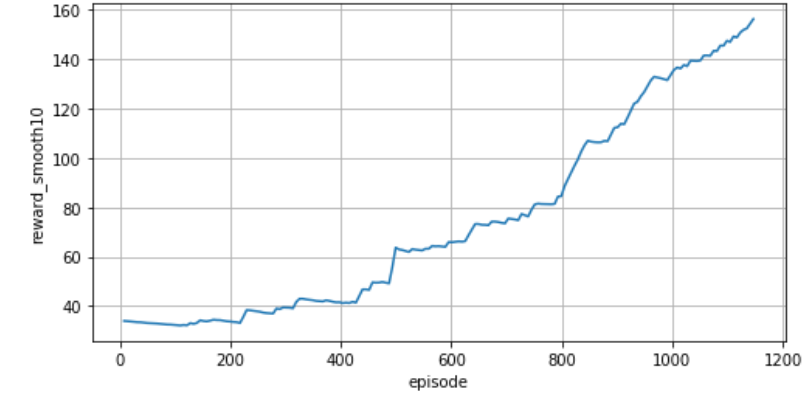
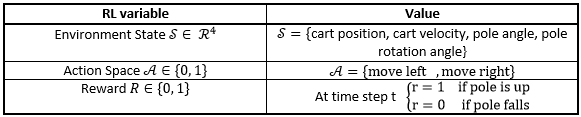
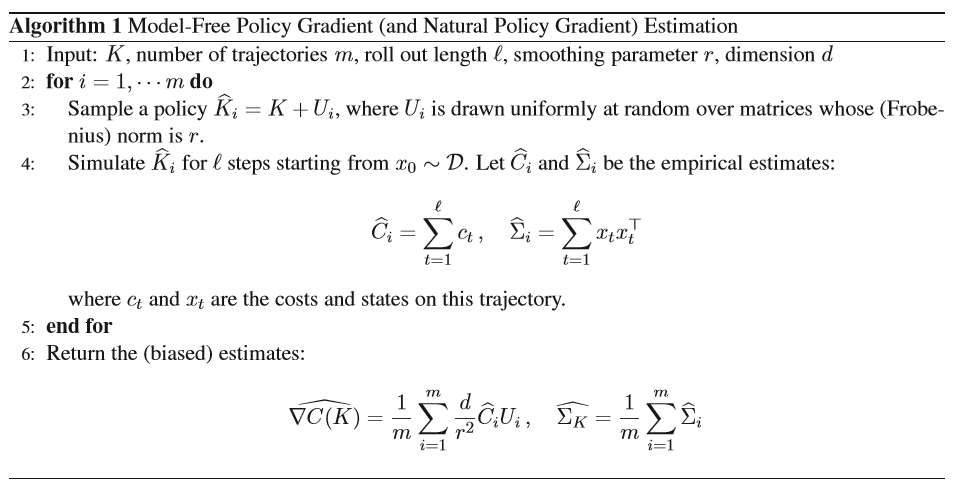
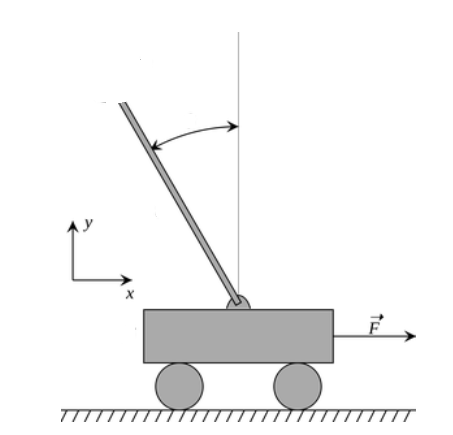
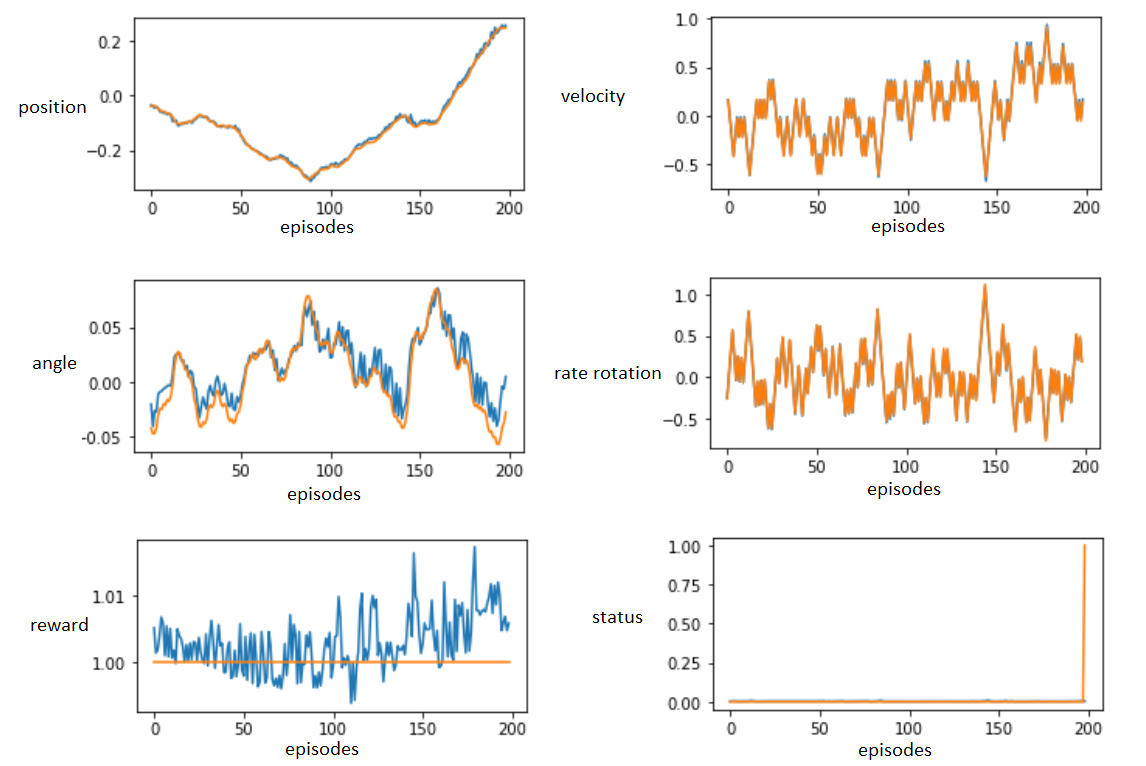
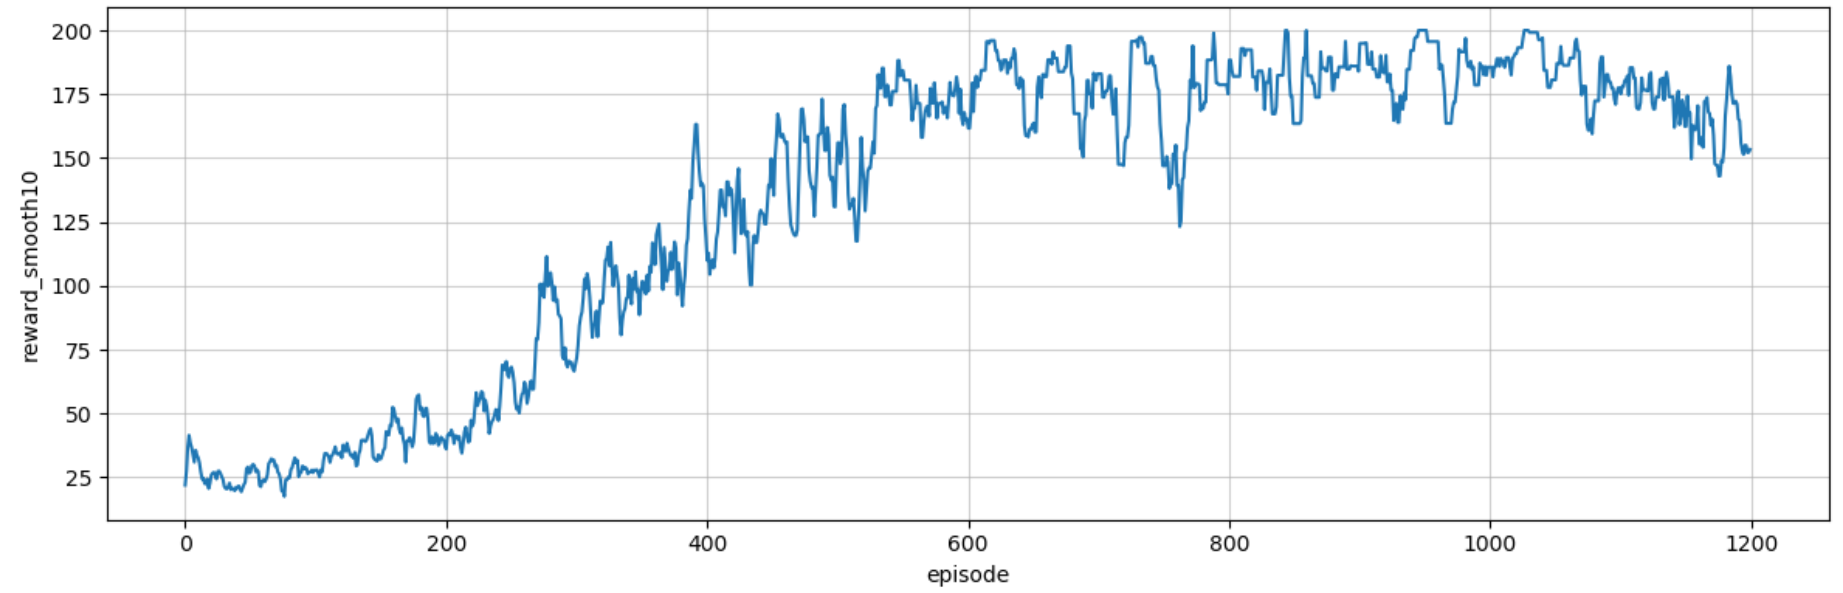
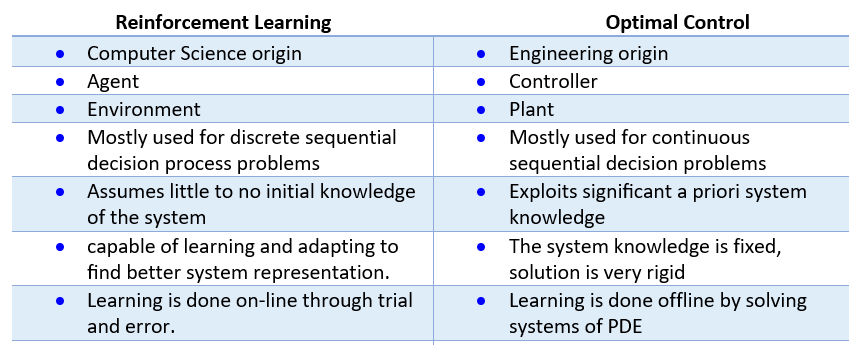